In [1]:
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import control
import control.matlab
%matplotlib inline 

Здесь мы импортировали 

<ipython-input-17-e98789521827>:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tau = np.array([u,0])


kplace: [[301.88634359 282.30267013 139.79832777  78.09916389]]
place eig: [-8. -6. -4. -2.]
klqr: [[190.50163723 190.45068305  88.8522519   51.17213021]]
lqr eig: [-8.21307115 -4.08241293 -2.30869766 -2.48782679]


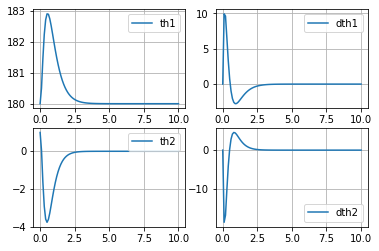

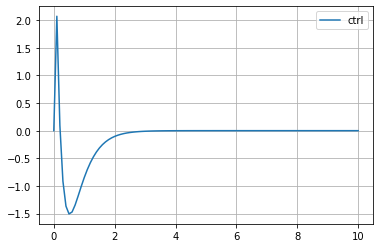

In [17]:
class Model:

    kp = np.array([60, 75, 30, 20])
    ki = np.array([0,0,0,0])
    x0 = np.array([math.pi,1*math.pi/180,0,0])
    xd = np.array([math.pi,0,0,0])
    dt = 0.1
    tt = np.array([0, dt])
    T = 10
    TT = np.arange(0,T+dt,dt)
    u0 = 0
    xx = np.array(x0)
    uu = np.array([0])
    ei = np.array([0,0,0,0])
    kplace = []
    klqr = []
    kdlqr = np.array([109.0628, 118.649, 51.8250, 30.9129])

    def du(in_,t,ep):
        return ep
    
    def place(self, x):
        ep = x-self.xd
        u = self.kplace @ ep
        return u[0,0]
    
    def lqr(self, x):
        ep = x-self.xd
        u = self.klqr @ ep
        return u[0,0]
    
    def dlqr(self, x):
        ep = x-self.xd
        u = self.kdlqr @ ep
        return u
    
    def pid(self, x):
        ep = x-self.xd
        self.ei = odeint(Model.du,self.ei,self.tt,args=(ep,))[-1]
        u = self.kp @ ep + self.ki @ self.ei
        return u

    def ctrl(self,x):
        return self.dlqr(x)

    def rp(in_,t,u):
        x = in_
        
        th1 = x[0]
        th2 = x[1]
        dth1 = x[2]
        dth2 = x[3]
        w = np.array([dth1,dth2])
        
        tau = np.array([u,0])
        m1 = 1
        m2 = 1
        L1 = 1
        L2 = 1
        g = 9.8
        f = np.array([0.6,0.6])

        D = np.array([[(m1+m2)*L1*L1+m2*L2*L2+2*m2*L1*L2*math.cos(th2), m2*L2*L2+m2*L1*L2*math.cos(th2)],
                     [m2*L2*L2+m2*L1*L2*math.cos(th2), m2*L2*L2]])

        C = np.array([-m2*L1*L2*math.sin(th2)*dth2*(2*dth1+dth2),
             m2*L1*L2*math.sin(th2)*dth1*dth1])

        g = np.array([(m1+m2)*g*L1*math.sin(th1)+m2*g*L2*math.sin(th1+th2),
            m2*g*L2*math.sin(th1+th2)])

        expr1 = tau - C - g - f*w
        ddth = np.linalg.inv(D) @ expr1
        dx = np.concatenate((w,
              ddth))
        
        return dx
    
    # for linearization
    def rhs(t, x, u, params):
        return Model.rp(x, t, u)

    def state(self,u,x0):
        x = odeint(Model.rp,x0,self.tt,args=(u,))[-1,:]
        return x

    def step(self,x0,u0):
        u = self.ctrl(x0)
        x = self.state(u,x0)
        return (x,u)

    def main_cycle(self):
        x = self.x0
        u = self.u0
        for t in self.TT[1:]:
            (x,u) = self.step(x,u)
            self.xx = np.vstack((self.xx,x))
            self.uu = np.vstack((self.uu,u))
            
    def linearize(self):
        #_rhs(t, x, u, params)
        #_out(t, x, u, params)
        two_link = control.NonlinearIOSystem(Model.rhs, inputs = 1)
        ss_sys = control.iosys.linearize(sys = two_link, xeq = self.xd, ueq = 0)
        A = ss_sys.A
        B = ss_sys.B
#         print(f"A: {A}")
#         print(f"B: {B}")
        p = 2*np.array([-1,-2,-3,-4])
        self.kplace = -control.matlab.place(A,B,p)
        print(f"kplace: {self.kplace}")
        w,v = np.linalg.eig(A + B @ self.kplace)
        print(f"place eig: {w}")
        
        Q = np.diag(np.array([1, 1, 1, 1]))
        R = 1
        self.klqr,S,E = control.lqr(A,B,Q,R)
        self.klqr = -self.klqr
        print(f"klqr: {self.klqr}")
        w,v = np.linalg.eig(A + B @ self.klqr)
        print(f"lqr eig: {w}")     
        
    def __init__(self):
        self.linearize()
        pass

m = Model()
m.main_cycle()
m.xx *= 180/math.pi

plt.figure(1)
plt.subplot(2,2,1)
plt.plot(m.TT,m.xx[:,0],label='th1')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(m.TT,m.xx[:,1],label='th2')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(m.TT,m.xx[:,2],label='dth1')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(m.TT,m.xx[:,3],label='dth2')
plt.legend()
plt.grid()

plt.figure(2)
plt.plot(m.TT,m.uu,label='ctrl')
plt.legend()
plt.grid()

